# MAE 598 Project 1: Rocket Landing 

Aishwarya Ledalla
10/20/1021

# Documentation of the Problem Formulation:

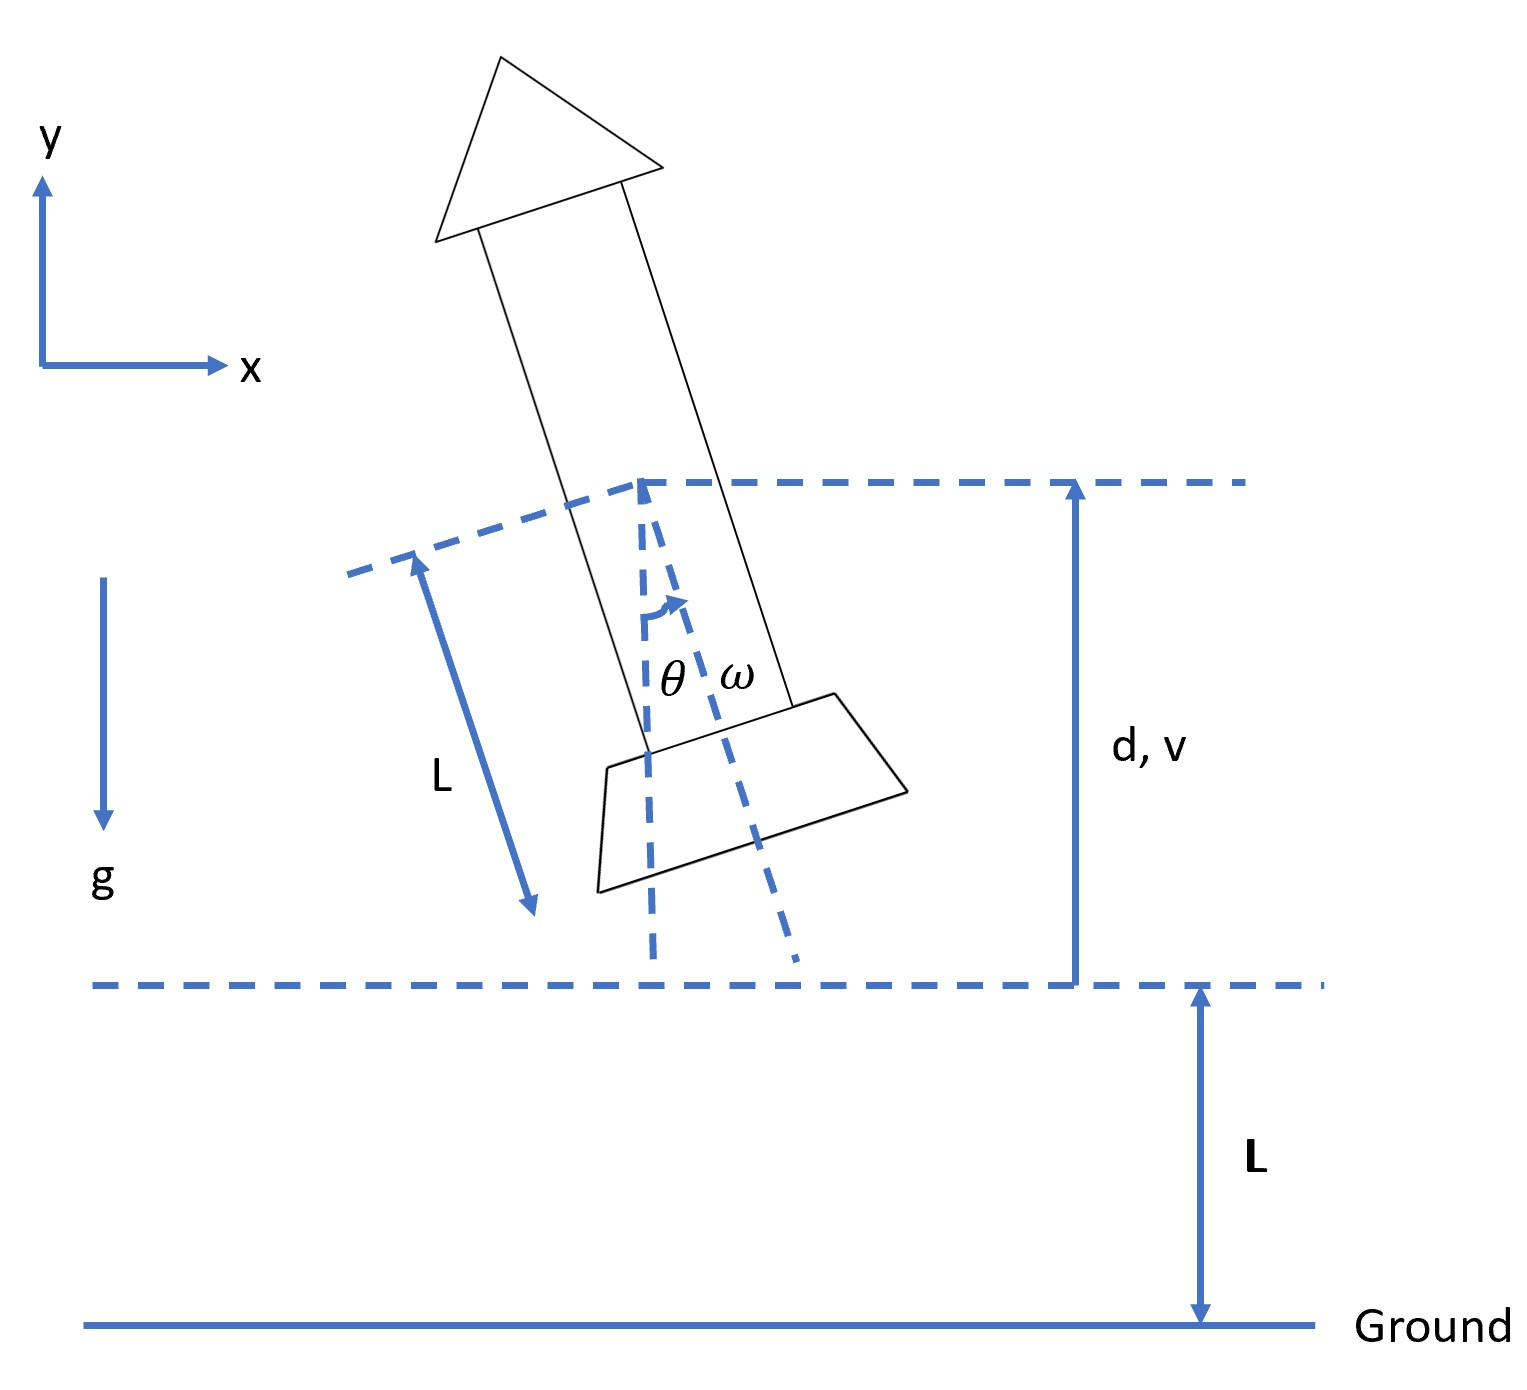

I chose to imporve the rocket landing problem by adding rocket orientation and angular velocity to its state space. I assumed there is gravity present, there is no drag, and the rocket is confined to 2D space. The state of the rocket as it goes into landing is $x(t) = [d(t), v(t), \theta (t), \omega (t)]^T$, where d is the rocket's distance from its center of gravity to a point L from the ground, v is the rocket's velocity, $\theta$ is the angle of the rocket with respect to the vertical, and $\omega$ is the rocket's angular velocity. All state variables are funtions of time. 

The control input is the rocket's acceleration which will be given by the neural network $f_n$ with $n$ parameters.

$$
a(t) = f_n(x(t))
$$

The parameters will be optimized to get optimal state conditions: $x(t) = 0$.

The loss/objective function is a function of the control input and the state: $l(x(t),a(t))$. Since $x(t) = 0$, set $l(x(t),a(t)) = 0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2 + \theta (T)^2 + \omega (T)^2$. The loss function makes sure the rocket reaches
landing conditions:

$$
\begin{aligned}
\quad d(T) = 0 \\
\quad v(T) = 0 \\
\quad \theta (T) = 0 \\
\quad \omega (T) = 0 \\
\end{aligned}
$$

The optimization problem formulation:

$$
\begin{aligned}
\min_n \quad||x(T)||^2 \\
\quad d(t+1) = d(t) + v(t) \Delta t, \\
\quad v(t+1) = d(t) + a(t) \Delta t, \\
\quad \theta (t+1) = \theta (t) + \omega (t) \Delta t, \\
\quad \omega (t+1) = \omega (t) + \alpha (t) \Delta t, \\
\quad a(t) = f_n(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

Assumptions:
1) The rocket lands When the center of gravity of the rocket reaches a distance L from the ground, where L is the hypothetical length from the center of the gravity of the rocket to the landing feet of the rocket.

2) $\alpha (t) = -arcsin(a(t) /L) = (Rotation Constant)*a(t)$

3) 2D simplification

4) Gravity is present

5) No drag





# Programming:

In [17]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [18]:
# environment parameters

FRAME_TIME = 0.01;  # time interval
GRAVITY_ACCEL = 0.12;  # gravity constant
BOOST_ACCEL = 0.18;  # thrust constant
ROTATION_ACCEL = 20;  # rotation constant

In [28]:
# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust and rotation
        state[0] = y
        state[1] = y_dot = v
        state[2] = theta
        state[3] = theta_dot = omega
        """
        
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Apply Thrust
        delta_state_thrust = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action

        # Apply Rotation 
        delta_state_rotation = ROTATION_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., -1.]) * action

        # Update velocity and angular velocity
        state = state + delta_state_gravity + delta_state_thrust + delta_state_rotation
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [29]:
# a deterministic controller
# Note:
# 0. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
            )

    def forward(self, state):
        action = self.network(state)
        return action

In [30]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [0., 0., 0., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [48]:
# set up the optimizer
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        w = data[:, 3]
        plt.plot(x, y, x, z, x, w, y, z, y, w)
        plt.legend(['d vs. v','d vs. \u03B8','d vs. \u03A9','v vs. \u03B8','v vs. \u03C9'])
        plt.show()
        plt.plot(x, y, z, w)
        plt.legend(['d vs. v','\u03B8 vs. \u03C9'])
        plt.show()

[1] loss: 34.487


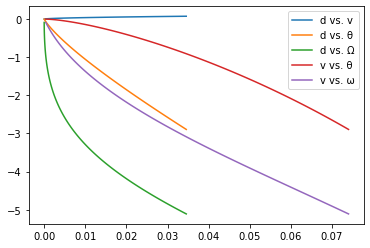

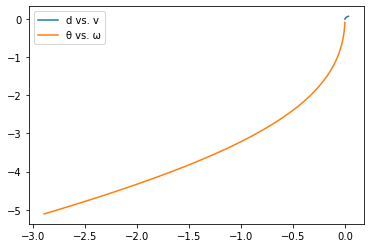

[2] loss: 23.127


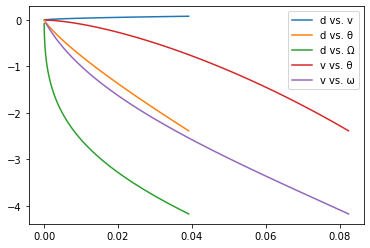

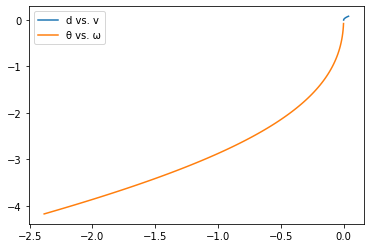

[3] loss: 12.504


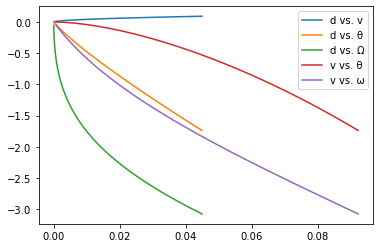

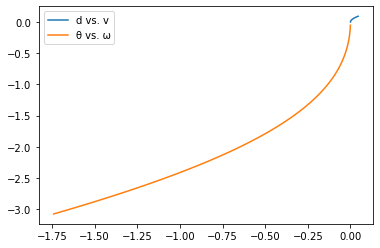

[4] loss: 8.438


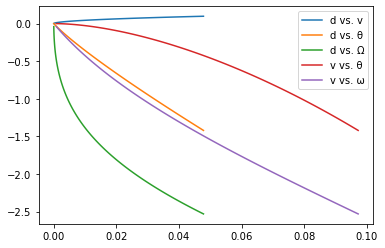

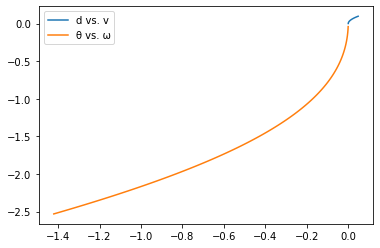

[5] loss: 5.136


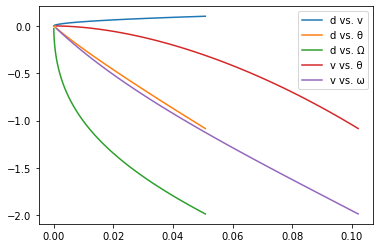

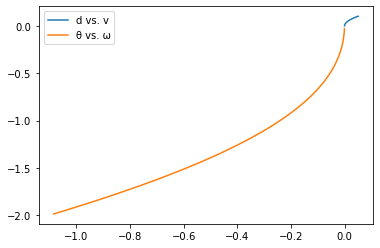

[6] loss: 3.053


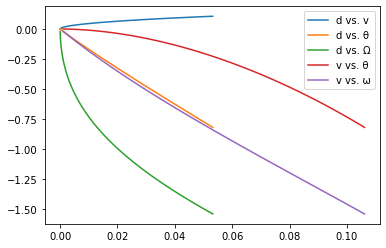

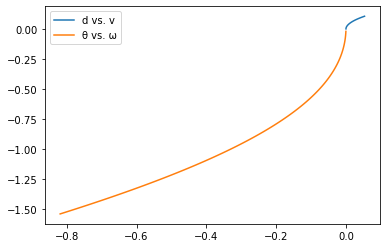

[7] loss: 2.040


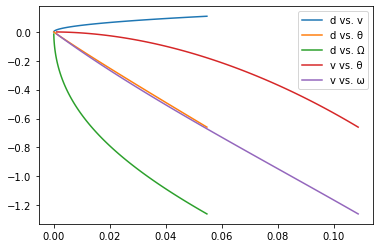

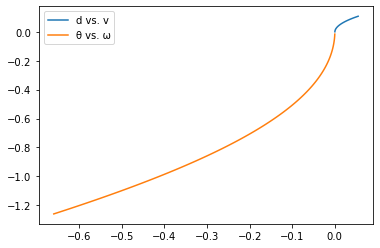

[8] loss: 1.386


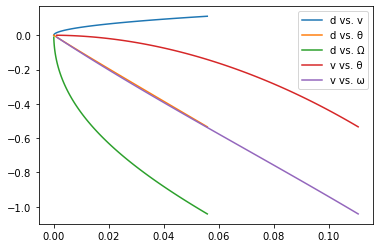

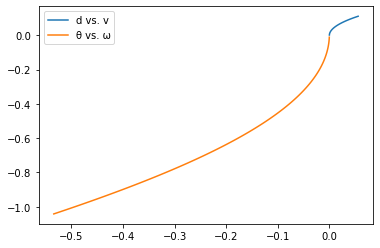

[9] loss: 0.952


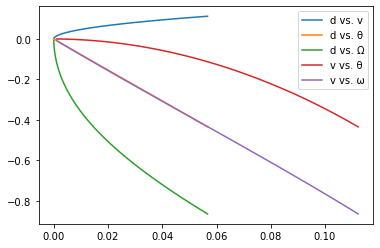

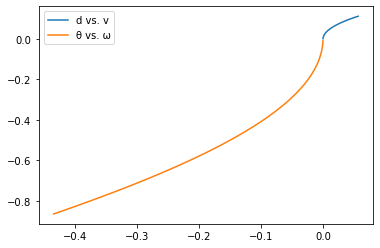

[10] loss: 0.623


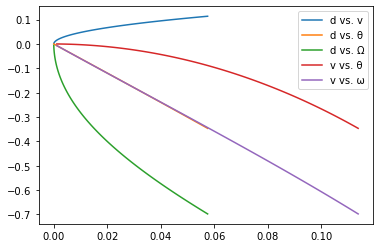

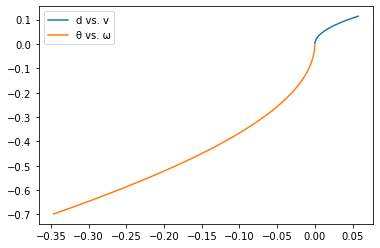

[11] loss: 0.388


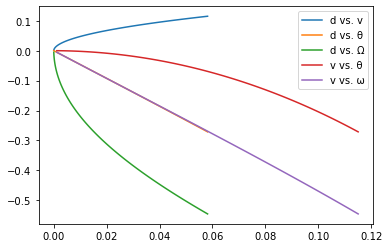

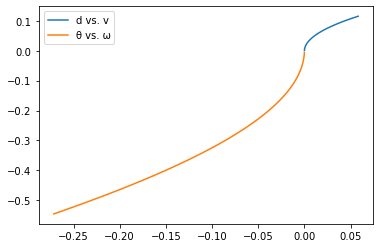

[12] loss: 0.259


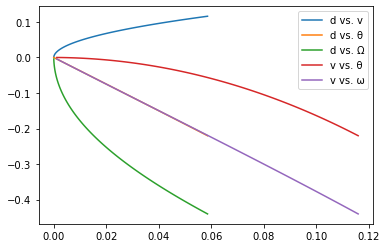

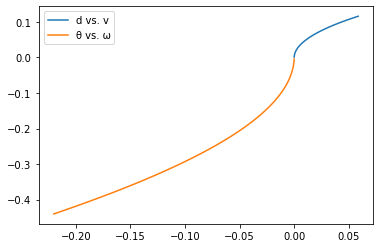

[13] loss: 0.181


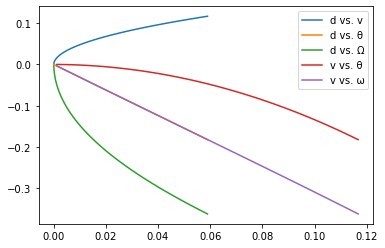

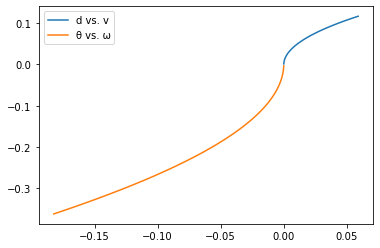

[14] loss: 0.128


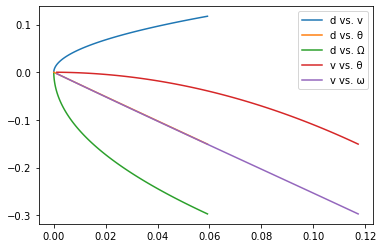

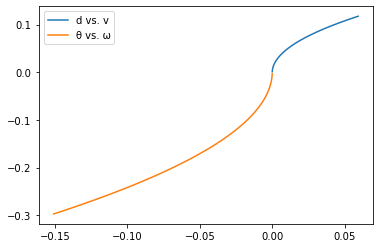

[15] loss: 0.090


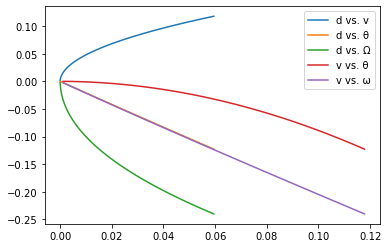

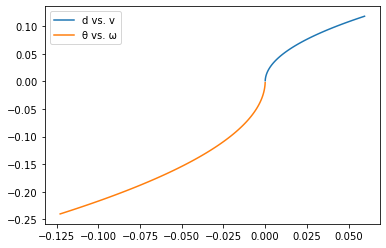

[16] loss: 0.058


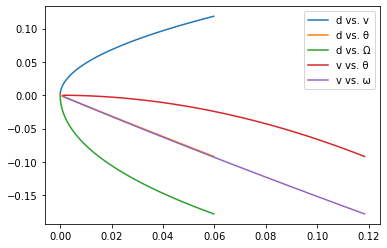

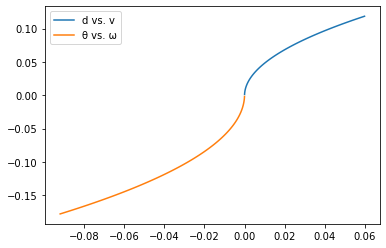

[17] loss: 0.041


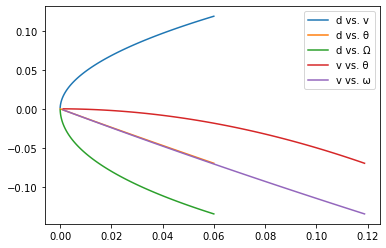

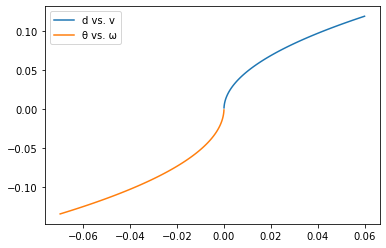

[18] loss: 0.033


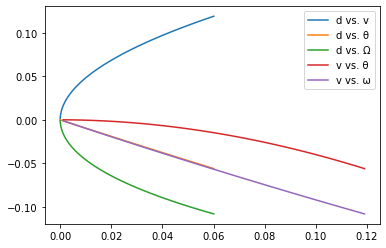

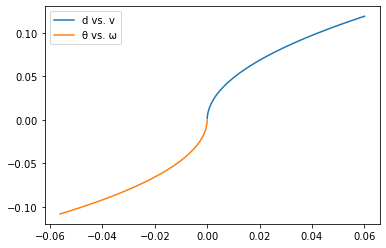

[19] loss: 0.027


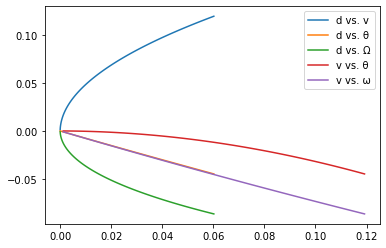

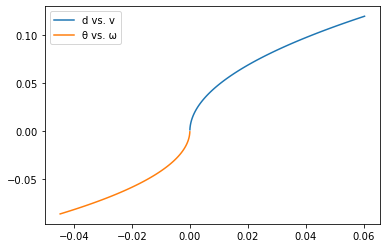

[20] loss: 0.023


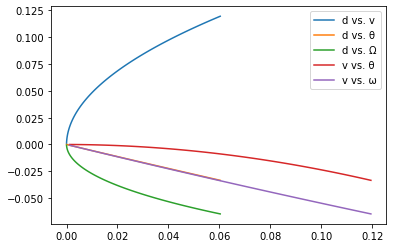

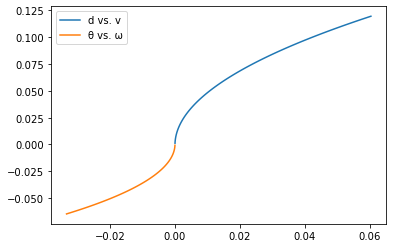

[21] loss: 0.021


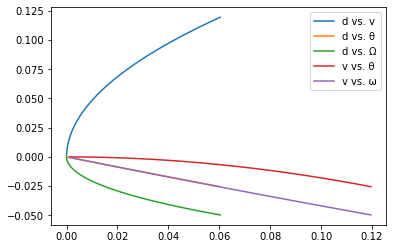

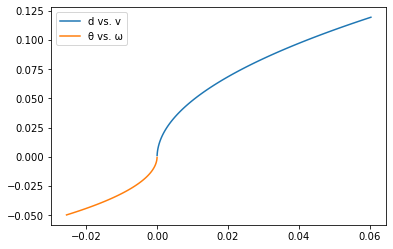

[22] loss: 0.020


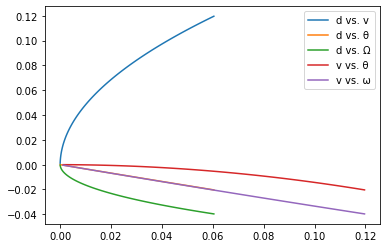

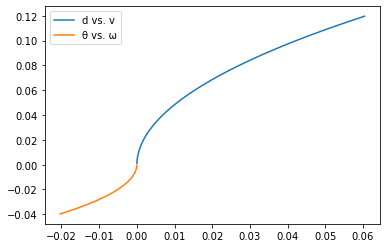

[23] loss: 0.019


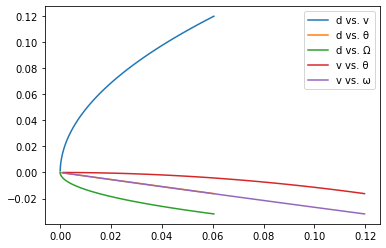

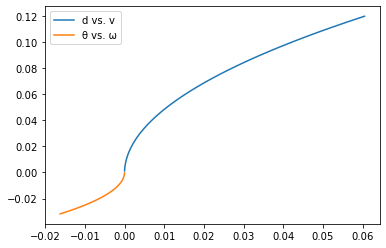

[24] loss: 0.019


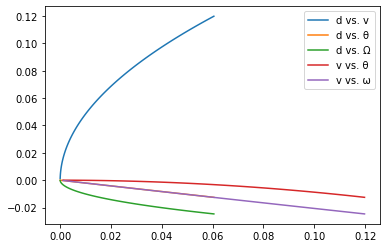

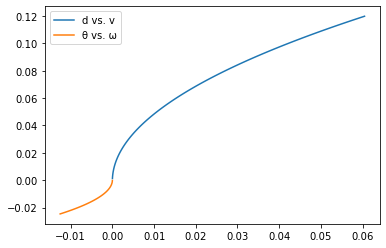

[25] loss: 0.018


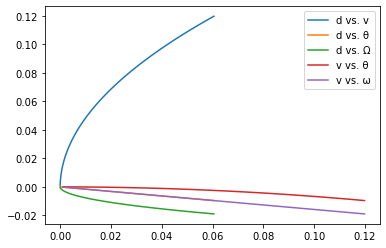

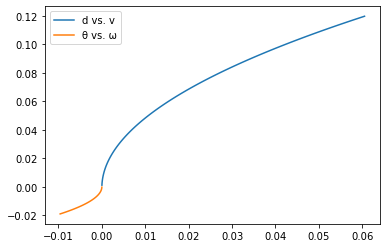

[26] loss: 0.018


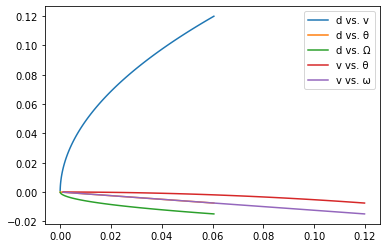

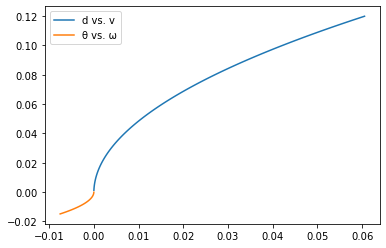

[27] loss: 0.018


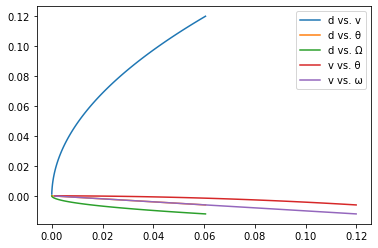

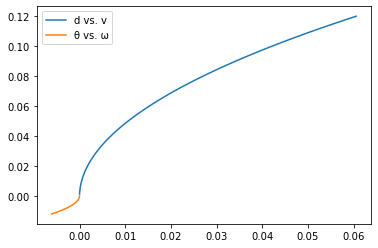

[28] loss: 0.018


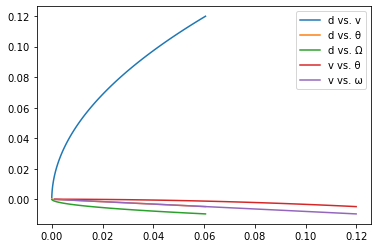

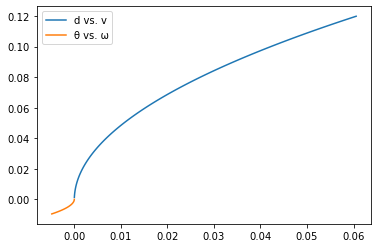

[29] loss: 0.018


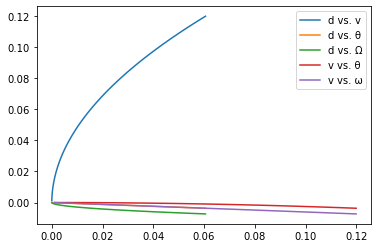

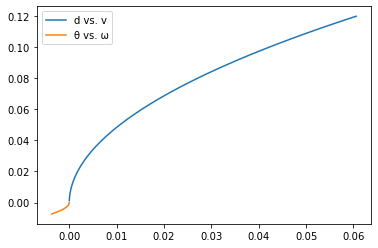

[30] loss: 0.018


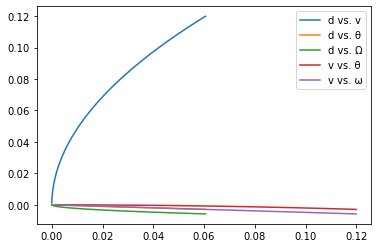

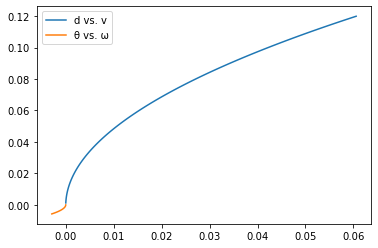

[31] loss: 0.018


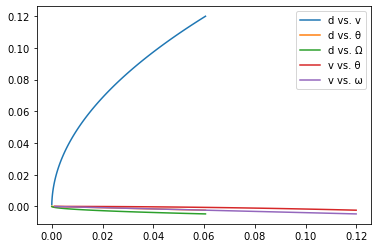

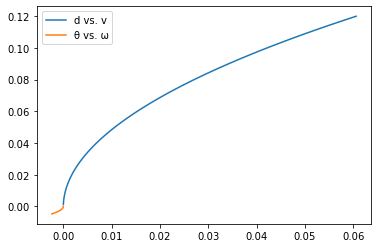

[32] loss: 0.018


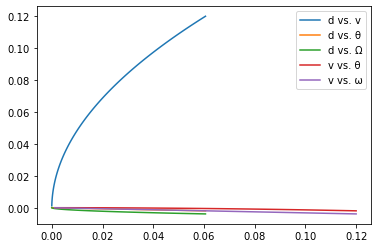

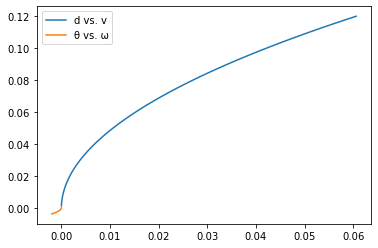

[33] loss: 0.018


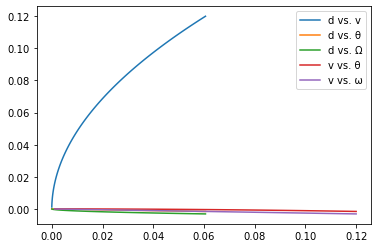

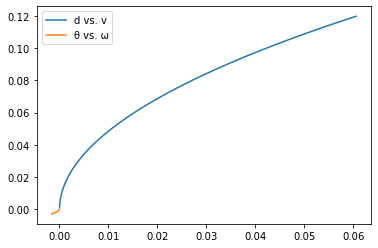

[34] loss: 0.018


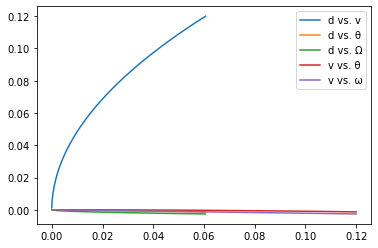

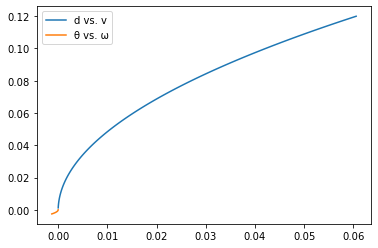

[35] loss: 0.018


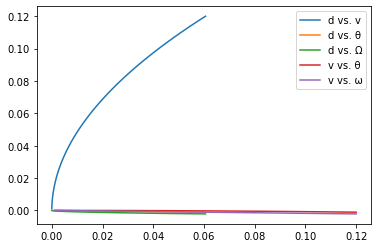

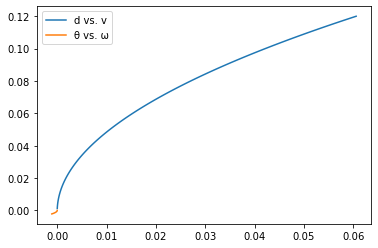

In [49]:
# Optimize Rocket Landing     

T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 5  # latent dimensions
dim_output = 1  # action space dimensions (there are 2 {acceleration and angular acceleration} but both use the same neural net)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(35)  # solve the optimization problem

# Analysis of the results: 

All the trajectories of the state converge to 0, making sure the rocket lands under proper landing conditions. Since this is a fourth order state space, I printed 5 plots to show the relationship between all 4 state variables. The second set of plots show convergence. At first d vs. v is dominant but slowly, the $\theta$ vs. $\omega$ plot becomes dominant, showing convergence of the variables to 0.